# Исследование рынка AI и Data ролей в регионе DACH (2026)
Анализ востребованности новых IT-специальностей в Германии, Австрии и Швейцарии.

- **Data Source**: Adzuna, StepStone, Xing, Arbeitsagentur.
- **Goal**: Сравнение уровней зарплат и навыков для востребованных ролей.
- **Plan**: Полная стратегия анализа доступна в [ROADMAP.md](../ROADMAP.md).


In [90]:
import sys
import os
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Добавляем пути для доступа к модулям проекта
project_root = os.path.abspath('..')
src_path = os.path.join(project_root, 'src')
if project_root not in sys.path:
    sys.path.append(project_root)
if src_path not in sys.path:
    sys.path.append(src_path)

# Настройка визуализации
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Все библиотеки и пути настроены.")

✅ Все библиотеки и пути настроены.


## 1. Сбор и подготовка данных
Мы используем **Adzuna** как единую точку входа. 

**Важно понимать:** Adzuna — это агрегатор. Когда мы делаем запрос через их API, мы получаем данные одновременно со **StepStone**, **Indeed**, **LinkedIn** и других площадок. Поэтому нам не нужно писать отдельный сложный скрапер для каждого сайта.


In [91]:
from src.database_manager import DatabaseManager

db_path = '../data/jobs_database.sqlite'
db_manager = DatabaseManager(db_path=db_path)

# Загружаем данные через менеджер
df = db_manager.get_all_vacancies()

if not df.empty:
    print(f"✅ Успешно загружено: {len(df)} вакансий")
    # Базовая предобработка
    df['Salary_Avg'] = (df['salary_min'] + df['salary_max']) / 2
    
    # Нормализация зарплат (CHF -> EUR)
    chf_to_eur = 1.06
    def normalize_val(val, country):
        if pd.isna(val) or val == 0: return np.nan
        return val * chf_to_eur if country == 'CH' else val

    df['salary_min_eur'] = df.apply(lambda r: normalize_val(r['salary_min'], r['country_api']), axis=1)
    df['salary_max_eur'] = df.apply(lambda r: normalize_val(r['salary_max'], r['country_api']), axis=1)
    df['salary_avg_eur'] = (df['salary_min_eur'] + df['salary_max_eur']) / 2
    
else:
    print("⚠️ База данных пуста или не найдена.")

df.sample(min(3, len(df))) if not df.empty else "No data"

✅ Успешно загружено: 9649 вакансий


,internal_id,signature,api_id,title,company,location,country_api,salary_min,salary_max,description,...,search_level,first_seen,last_seen,source,salary_is_predicted,extracted_skills,Salary_Avg,salary_min_eur,salary_max_eur,salary_avg_eur
4756,8222,04dee235dfd010a140b1529b669a79d1,5601847689,Senior Security Engineer - Künstliche Intellig...,BWI GmbH,Koeln,DE,NaN,NaN,Als primärer Digitalisierungspartner der Bunde...,...,None,2026-01-29,2026-01-29,adzuna,1,None,NaN,NaN,NaN,NaN
4392,7761,f8297efc01c6637b053c80685d79ec93,5597627061,100% Remote: Senior Machine Learning / NLP Eng...,Nemensis Ag,Deutschland,DE,NaN,NaN,Stellenbeschreibung Laufzeit: Feb/März - 12 Mo...,...,None,2026-01-29,2026-01-29,adzuna,1,None,NaN,NaN,NaN,NaN
8181,13530,713df08374fd669c23e2dc238b5e600e,5592508351,IT-Koordinator:in (w/m/x) für 2nd Level Support,ZHS Office- & Facilitymanagement GmbH,Wien,AT,NaN,NaN,IT-Koordinator:in (w/m/x) für 2nd Level Suppor...,...,None,2026-01-29,2026-01-29,adzuna,1,None,NaN,NaN,NaN,NaN


## 3. Сравнение всех источников данных
Мы сравниваем данные из четырех различных источников:
1. **Adzuna** — глобальный агрегатор.
2. **StepStone** — один из крупнейших порталов вакансий в Европе.
3. **Xing** — профессиональная сеть, популярная в регионе DACH.
4. **Arbeitsagentur** — федеральное агентство занятости Германии.

Это позволяет оценить, какой ресурс дает наибольший охват для конкретных ролей и где данные о зарплатах наиболее полные.

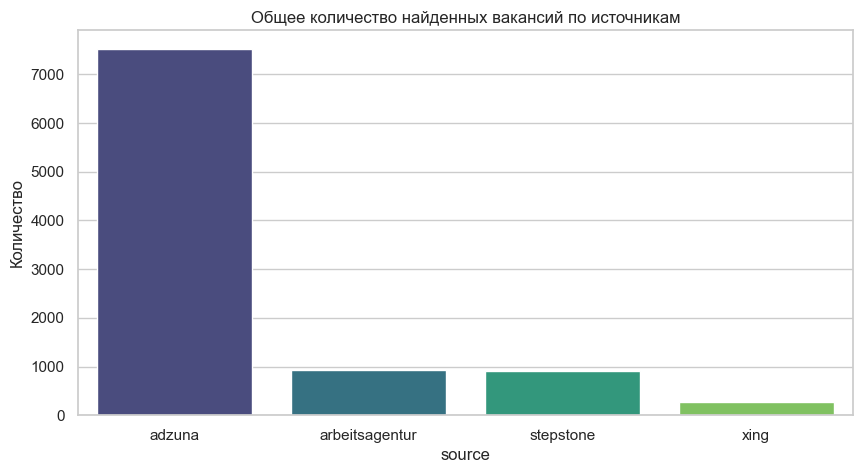

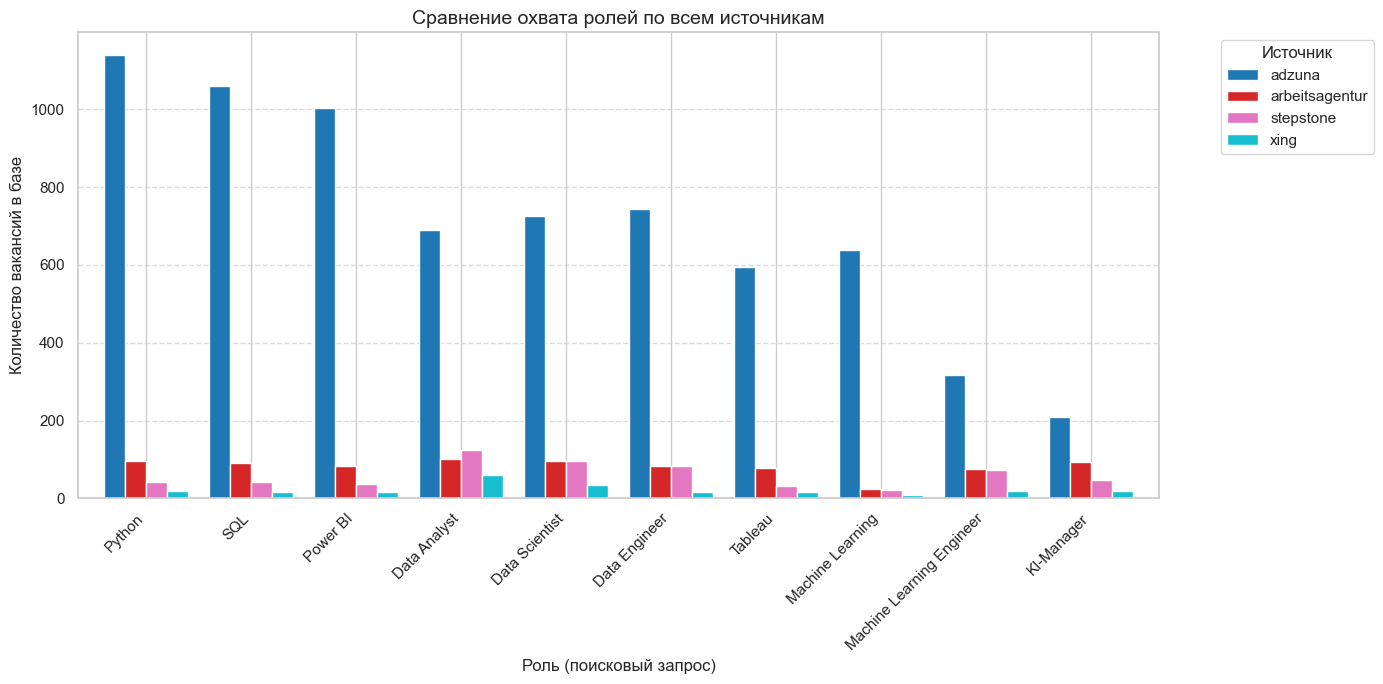

In [92]:
# 1. Сравнение общего количества вакансий
plt.figure(figsize=(10, 5))
source_counts = df['source'].value_counts()
sns.barplot(x=source_counts.index, y=source_counts.values, hue=source_counts.index, palette='viridis', legend=False)
plt.title('Общее количество найденных вакансий по источникам')
plt.ylabel('Количество')
plt.show()

# 2. Детальное сравнение по ролям (рядом стоящие столбцы)
# Группируем данные для визуализации
role_source_df = df.groupby(['search_query', 'source']).size().unstack(fill_value=0)

# Ограничимся топ-10 ролями для читаемости
top_roles = df['search_query'].value_counts().nlargest(10).index
role_source_df = role_source_df.loc[top_roles]

# Используем стандартную палитру, чтобы она автоматически подстраивалась под число источников
role_source_df.plot(kind='bar', figsize=(14, 7), width=0.8, colormap='tab10')
plt.title('Сравнение охвата ролей по всем источникам', fontsize=14)
plt.xlabel('Роль (поисковый запрос)', fontsize=12)
plt.ylabel('Количество вакансий в базе', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Источник', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 3.2. Полнота данных и распределение зарплат по источникам
Разные площадки по-разному отображают информацию о зарплатах. Здесь мы сравним, где данные наиболее полные и как различаются уровни предложений.

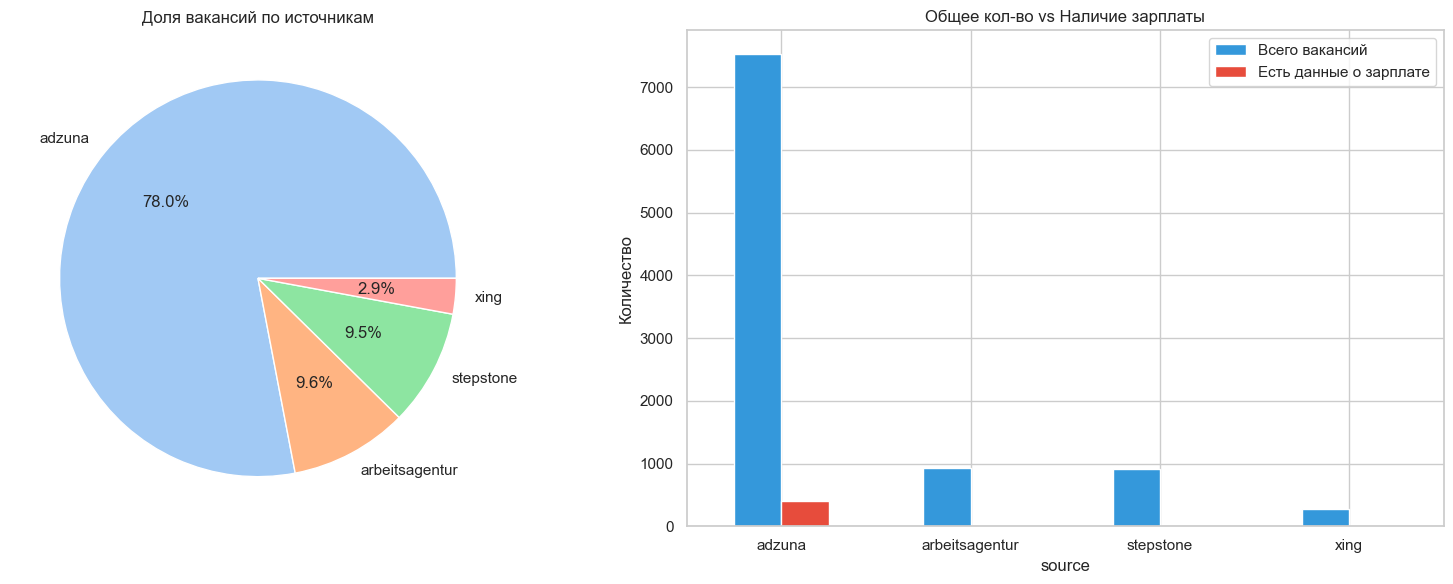

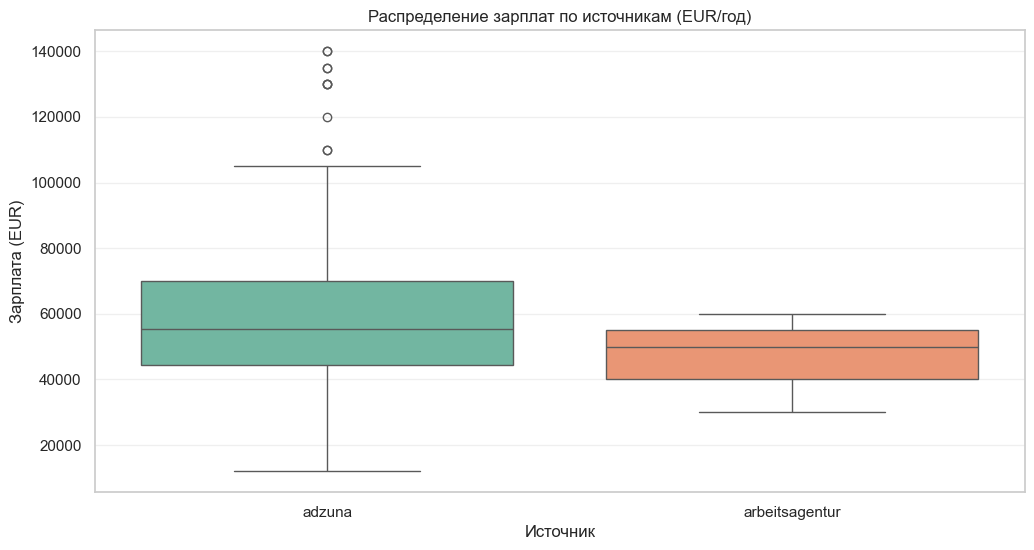

In [93]:
# Группировка данных по источникам
source_stats = df.groupby('source').agg({
    'signature': 'count',
    'salary_min': lambda x: x.notnull().sum()
}).rename(columns={'signature': 'Total Vacancies', 'salary_min': 'With Salary Info'})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Распределение по количеству вакансий
source_stats['Total Vacancies'].plot(kind='pie', autopct='%1.1f%%', ax=ax1, colors=sns.color_palette('pastel'))
ax1.set_title('Доля вакансий по источникам')
ax1.set_ylabel('')

# 2. Полнота данных по зарплатам
source_stats.plot(kind='bar', ax=ax2, color=['#3498db', '#e74c3c'])
ax2.set_title('Общее кол-во vs Наличие зарплаты')
ax2.set_ylabel('Количество')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.legend(['Всего вакансий', 'Есть данные о зарплате'])

plt.tight_layout()
plt.show()

# 3. Боксплот зарплат по источникам (только там, где есть данные)
# Исключаем аномально низкие значения (возможные ошибки парсинга или почасовые ставки)
df_sal_src = df[df['salary_min'] > 10000] 
if not df_sal_src.empty and df_sal_src['source'].nunique() > 1:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_sal_src, x='source', y='salary_min', hue='source', palette='Set2', legend=False)
    plt.title('Распределение зарплат по источникам (EUR/год)')
    plt.ylabel('Зарплата (EUR)')
    plt.xlabel('Источник')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
else:
    print("Недостаточно данных для сравнения зарплат между разными источниками.")

## 4. Анализ зарплат по городам и ролям
Здесь мы можем детально рассмотреть распределение зарплат для конкретных специализаций в разных городах региона DACH.

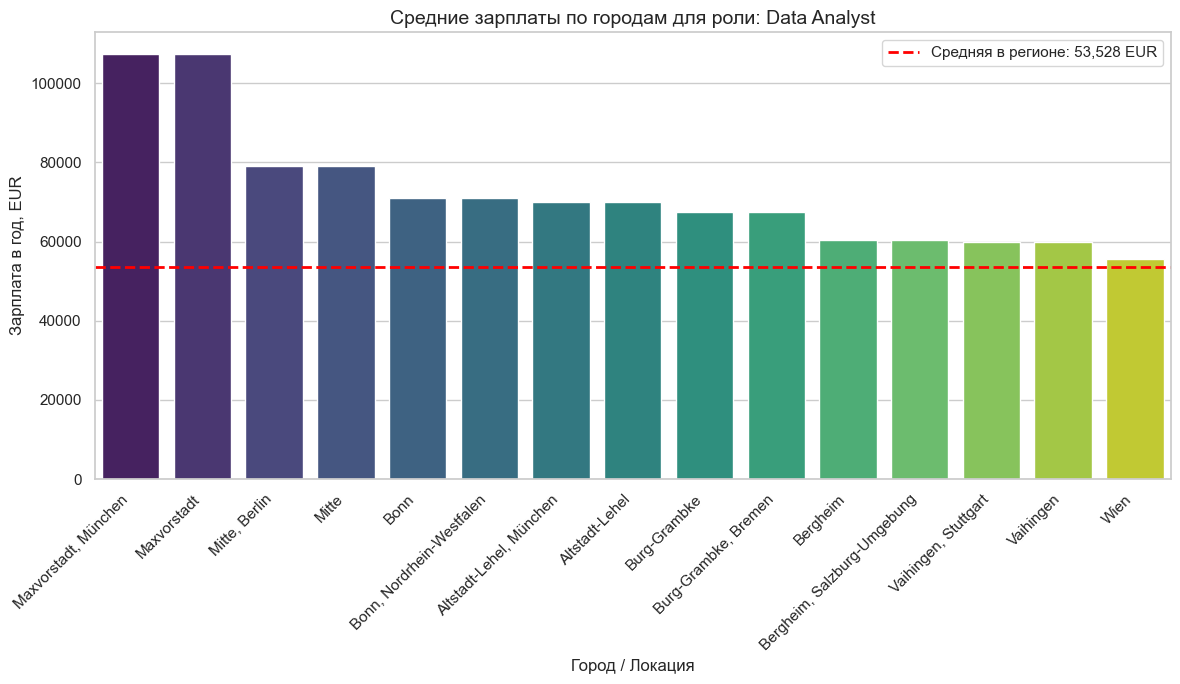

Роль: Data Analyst
Средняя по региону для этой роли: 53,528.05 EUR
Количество вакансий в анализе: 58


In [94]:
# 4. Анализ зарплат по городам и ролям
# Выбор категории для анализа (можно менять вручную)
selected_role = "Data Analyst" 

# Офильтровываем данные: только нужная роль и только годовые зарплаты (> 5000)
df_role = df[(df['search_query'].str.contains(selected_role, case=False, na=False)) & (df['salary_avg_eur'] > 10000)]

if not df_role.empty:
    # 1. Расчет средних по городам (используем location)
    city_stats = df_role.groupby('location')['salary_avg_eur'].mean().sort_values(ascending=False).head(15)
    
    # 2. Расчет средней по всей стране для этой роли
    national_avg = df_role['salary_avg_eur'].mean()
    
    plt.figure(figsize=(12, 7))
    sns.barplot(x=city_stats.index, y=city_stats.values, hue=city_stats.index, palette='viridis', legend=False)
    
    # 3. Добавление линии средней по стране
    plt.axhline(national_avg, color='red', linestyle='--', linewidth=2, label=f'Средняя в регионе: {national_avg:,.0f} EUR')
    
    plt.title(f'Средние зарплаты по городам для роли: {selected_role}', fontsize=14)
    plt.ylabel('Зарплата в год, EUR')
    plt.xlabel('Город / Локация')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Роль: {selected_role}")
    print(f"Средняя по региону для этой роли: {national_avg:,.2f} EUR")
    print(f"Количество вакансий в анализе: {len(df_role)}")
else:
    available_roles = df[df['salary_avg_eur'] > 10000]['search_query'].unique()
    print(f"Для роли '{selected_role}' недостаточно данных о зарплатах.")
    print(f"Доступные категории с зарплатами: {available_roles}")

## 5. Обзор рынка: Уровни (Junior vs Senior) и популярные роли
В этом разделе мы анализируем доступность вакансий для разных уровней опыта и распределение популярных ролей по странам региона DACH.

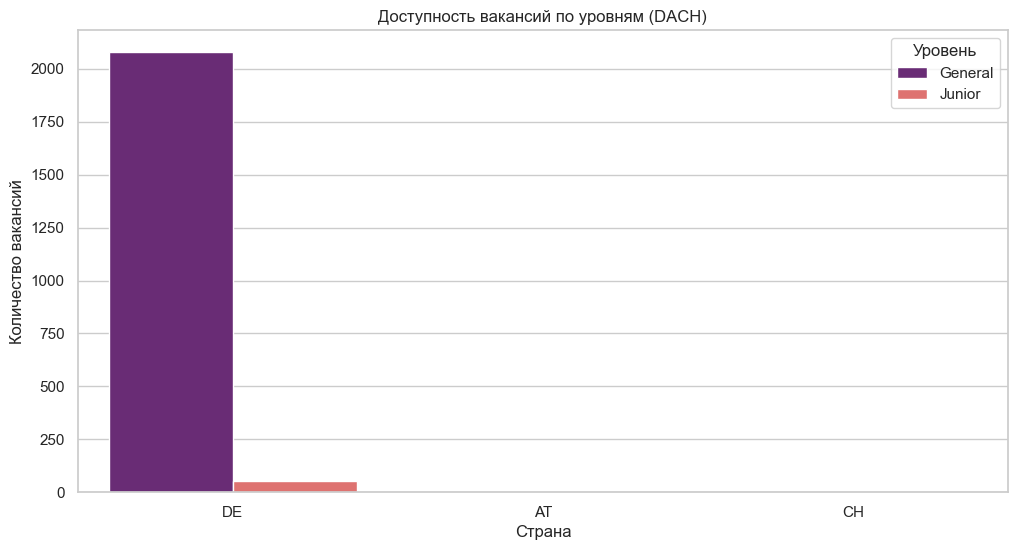

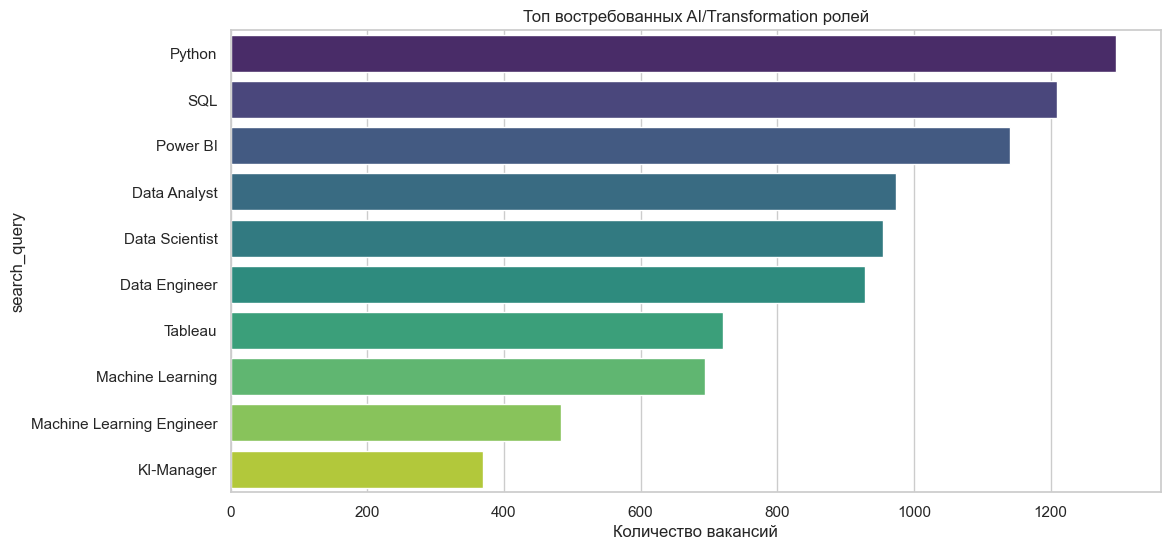

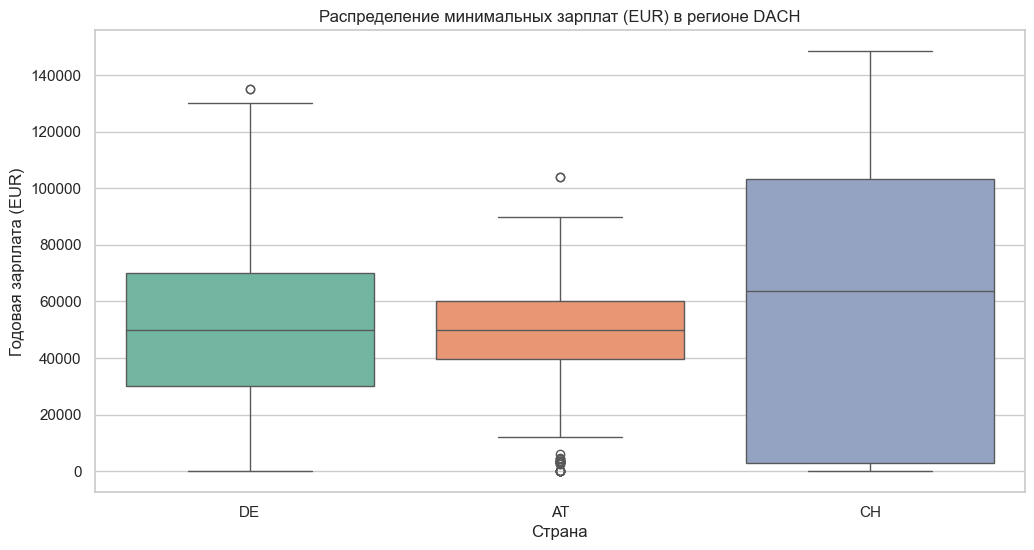

In [95]:
# 1. Анализ "Входа в рынок" (Junior vs Senior) по странам
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='country_api', hue='search_level', palette='magma')
plt.title('Доступность вакансий по уровням (DACH)')
plt.xlabel('Страна')
plt.ylabel('Количество вакансий')
plt.legend(title='Уровень')
plt.show()

# 2. Популярность новых ролей (Топ-10)
plt.figure(figsize=(12, 6))
role_counts = df['search_query'].value_counts().head(10)
sns.barplot(x=role_counts.values, y=role_counts.index, hue=role_counts.index, palette='viridis', legend=False)
plt.title('Топ востребованных AI/Transformation ролей')
plt.xlabel('Количество вакансий')
plt.show()

# 3. Визуализация зарплат по странам и уровням (используем уже нормализованные EUR)
plt.figure(figsize=(12, 6))
# Очищаем данные от NaN для построения графика
df_box = df.dropna(subset=['salary_min_eur', 'country_api'])

if not df_box.empty:
    has_hue = 'search_level' in df_box.columns and df_box['search_level'].nunique() > 1
    
    sns.boxplot(
        data=df_box, 
        x='country_api', 
        y='salary_min_eur', 
        hue='search_level' if has_hue else 'country_api', # Fix for Seaborn v0.13
        palette='Set2',
        legend=True if has_hue else False
    )
    plt.title('Распределение минимальных зарплат (EUR) в регионе DACH')
    plt.ylabel('Годовая зарплата (EUR)')
    plt.xlabel('Страна')
    plt.show()
else:
    print("Данных по зарплате пока недостаточно для построения BoxPlot.")

## 6. Анализ истории зарплат (Adzuna Trends)
Используем данные из статистики Adzuna для визуализации динамики предложений на рынке. (Требуется наличие файла `salary_history.json`).

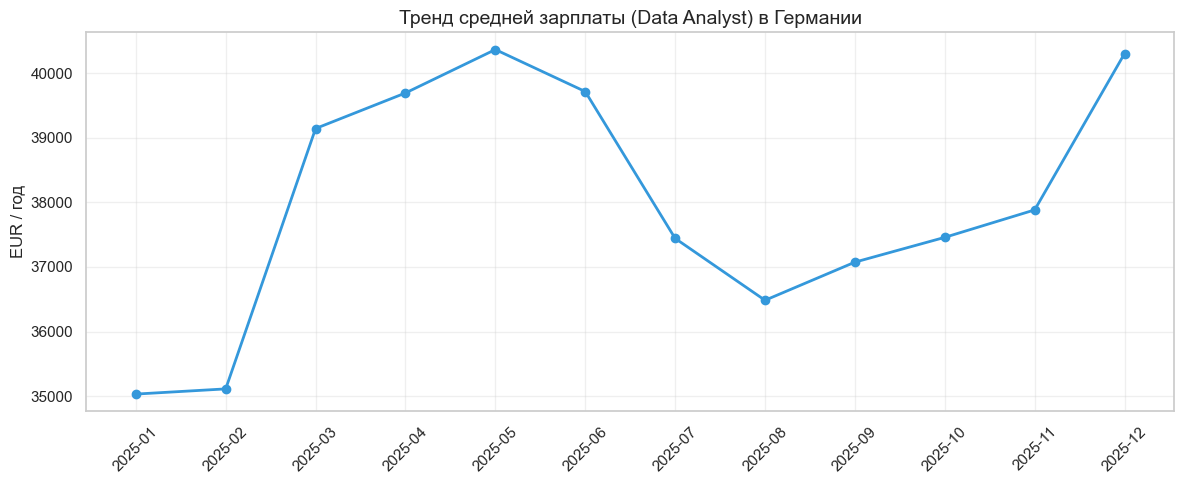

In [96]:
history_file = '../data/salary_history.json'

if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        hist_data = json.load(f)
    if 'month' in hist_data:
        # Извлекаем месяцы и значения
        months = sorted(hist_data['month'].keys())
        values = [hist_data['month'][m] for m in months]
        
        plt.figure(figsize=(12, 5))
        plt.plot(months, values, marker='o', linestyle='-', color='#3498db', linewidth=2)
        plt.title('Тренд средней зарплаты (Data Analyst) в Германии', fontsize=14)
        plt.xticks(rotation=45)
        plt.ylabel('EUR / год')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("В файле истории нет данных по месяцам.")
else:
    print("Файл истории не найден.")

## 7. Анализ «Срока жизни» вакансий
Как долго вакансия остается открытой? Это косвенный показатель дефицита кадров или сложности позиции. (Рассчитывается как разница между `first_seen` и `last_seen`).

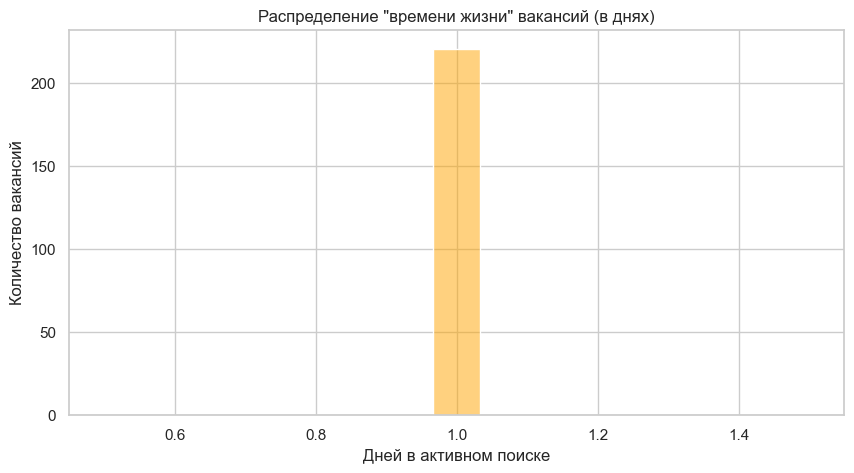

In [97]:
# 7. Анализ "Срока жизни" вакансий (Lifespan Analysis)
# Вычисляем разницу между первым и последним появлением вакансии
df['first_seen'] = pd.to_datetime(df['first_seen'])
df['last_seen'] = pd.to_datetime(df['last_seen'])
df['lifespan_days'] = (df['last_seen'] - df['first_seen']).dt.days

plt.figure(figsize=(10, 5))
# Фильтруем те, что висят более 0 дней (появились повторно)
active_jobs = df[df['lifespan_days'] > 0]

if not active_jobs.empty:
    sns.histplot(active_jobs['lifespan_days'], bins=15, kde=True, color='orange')
    plt.title('Распределение "времени жизни" вакансий (в днях)')
    plt.xlabel('Дней в активном поиске')
    plt.ylabel('Количество вакансий')
    plt.show()
else:
    print("Данных для анализа срока жизни пока недостаточно. Требуется повторный запуск сбора через 24 часа.")

## 8. Анализ ключевых навыков
В этом разделе мы анализируем частоту упоминания технологий и языков программирования в вакансиях.
Это позволяет понять, какие стеки наиболее востребованы для AI и Data ролей.

In [98]:
from src.skill_extractor import SkillExtractor

# Инициализируем экстрактор
extractor = SkillExtractor(db_path='../data/jobs_database.sqlite')

# 1. Топ навыков для Junior позиций
# Мы добавили фильтрацию по уровням в Pipeline, теперь можем смотреть разницу
query_junior = "SELECT extracted_skills FROM vacancies WHERE search_level = 'Junior' AND extracted_skills IS NOT NULL"
conn = sqlite3.connect('../data/jobs_database.sqlite')
jr_skills_df = pd.read_sql_query(query_junior, conn)
conn.close()

all_jr_skills = []
for s in jr_skills_df['extracted_skills']:
    if s: all_jr_skills.extend(s.split(", "))

jr_counts = Counter(all_jr_skills).most_common(15)
jr_df = pd.DataFrame(jr_counts, columns=['Skill', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=jr_df, x='Count', y='Skill', hue='Skill', palette='magma', legend=False)
plt.title('Ключевые навыки для JUNIOR специалистов (DACH)', fontsize=15)
plt.xlabel('Количество упоминаний')
plt.show()

# 2. Общий топ навыков (для сравнения)
top_skills = extractor.get_top_skills()
if top_skills:
    skills_df = pd.DataFrame(top_skills, columns=['Skill', 'Count'])
    plt.figure(figsize=(12, 6))
    sns.barplot(data=skills_df, x='Count', y='Skill', hue='Skill', palette='viridis', legend=False)
    plt.title('Топ востребованных навыков (Общий рынок)', fontsize=15)
    plt.show()
else:
    print("Данные по навыкам еще не извлечены. Запустите Pipeline.")

NameError: name 'Counter' is not defined